In [1]:
using AutomotiveDrivingModels
using AutoViz
using Interact

In [2]:
# not relevant to the bug
function simulate!(scene::Scene, models::Dict{Int, DriverModel},
        roadway::Roadway, rec::SceneRecord, T::Float64)
    actions = Array(DriveAction, length(scene))
    for t in 0:rec.timestep:(T - rec.timestep)
        get_actions!(actions, scene, roadway, models)
        tick!(scene, roadway, actions, models)
        AutomotiveDrivingModels.update!(rec, scene)
    end
    return rec
end

simulate! (generic function with 1 method)

In [ ]:
# function containing bug
# set with_fix option for temporary solution
# with_fix = true keeps track of which neighbors have already been evaluated as being 
# in front of the ego vehicle and skips them in later iterations of the while loop
function AutomotiveDrivingModels.get_neighbor_rear_along_lane(
    scene::Scene,
    roadway::Roadway,
    tag_start::LaneTag,
    s_base::Float64,
    targetpoint_primary::VehicleTargetPoint, # the reference point whose distance we want to minimize
    targetpoint_valid::VehicleTargetPoint; # the reference point, which if distance to is positive, we include the vehicle
    max_distance_rear::Float64 = 250.0, # max distance to search rearward [m]
    index_to_ignore::Int=-1,
    with_fix::Bool=false
    )
    best_ind = 0
    best_dist = max_distance_rear
    tag_target = tag_start
    
    ignore = Set{Int}()

    dist_searched = 0.0
    while dist_searched < max_distance_rear

        lane = roadway[tag_target]
        for (i,veh) in enumerate(scene)
            if i != index_to_ignore && !in(veh.def.id, ignore)

                s_adjust = NaN

                if veh.state.posF.roadind.tag == tag_target
                    s_adjust = 0.0

                elseif is_between_segments_hi(veh.state.posF.roadind.ind, lane.curve) &&
                       is_in_entrances(roadway[tag_target], veh.state.posF.roadind.tag)

                    distance_between_lanes = abs(roadway[tag_target].curve[1].pos - roadway[veh.state.posF.roadind.tag].curve[end].pos)
                    s_adjust = -(roadway[veh.state.posF.roadind.tag].curve[end].s + distance_between_lanes)

                elseif is_between_segments_lo(veh.state.posF.roadind.ind) &&
                       is_in_exits(roadway[tag_target], veh.state.posF.roadind.tag)

                    distance_between_lanes = abs(roadway[tag_target].curve[end].pos - roadway[veh.state.posF.roadind.tag].curve[1].pos)
                    s_adjust = roadway[tag_target].curve[end].s + distance_between_lanes
                end
                

                if !isnan(s_adjust)
                    s_valid = veh.state.posF.s + get_targetpoint_delta(targetpoint_valid, veh) + s_adjust
                    dist_valid = s_base - s_valid + dist_searched
                    
                    if dist_valid ≥ 0.0
                        s_primary = veh.state.posF.s + get_targetpoint_delta(targetpoint_primary, veh) + s_adjust
                        dist = s_base - s_primary + dist_searched
                        
                        if dist < best_dist
                            best_dist = dist
                            best_ind = i
                        end
                    else
                        if with_fix
                            push!(ignore, veh.def.id)
                        end
                    end
                end
            end
        end

        if best_ind != 0
            break
        end

        if !has_prev(lane) ||
           (tag_target == tag_start && dist_searched != 0.0) # exit after visiting this lane a 2nd time
            break
        end

        dist_searched += s_base
        s_base = lane.curve[end].s + abs(lane.curve[end].pos - prev_lane_point(lane, roadway).pos) # end of prev lane plus crossover
        tag_target = prev_lane(lane, roadway).tag
    end
    NeighborLongitudinalResult(best_ind, best_dist)
end


In [3]:
# minimal bug example
# get_neighbor_rear_along_lane returns the neighbor fore along lane rather than the neighbor rear
# when the rear is in a different road segment

context = IntegratedContinuous(.1, 1)
num_veh = 3
num_lanes = 1
roadway = gen_stadium_roadway(num_lanes, length = 400.0, radius = 100.0)

# build the scene
scene = Scene(num_veh)

base_speed = 10.
road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = 0.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(1, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_pos = -20.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(2, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

road_pos = 20.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(3, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

models = Dict{Int,DriverModel}()
for veh_id in 1:num_veh
    models[veh_id] = Tim2DDriver(context)
end

rec = SceneRecord(500, .1, num_veh)
T = 5.
simulate!(scene, models, roadway, rec, T)

SceneRecord(nscenes=50)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(24, nactions=1),"i",24,"24",Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3),Dict(2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

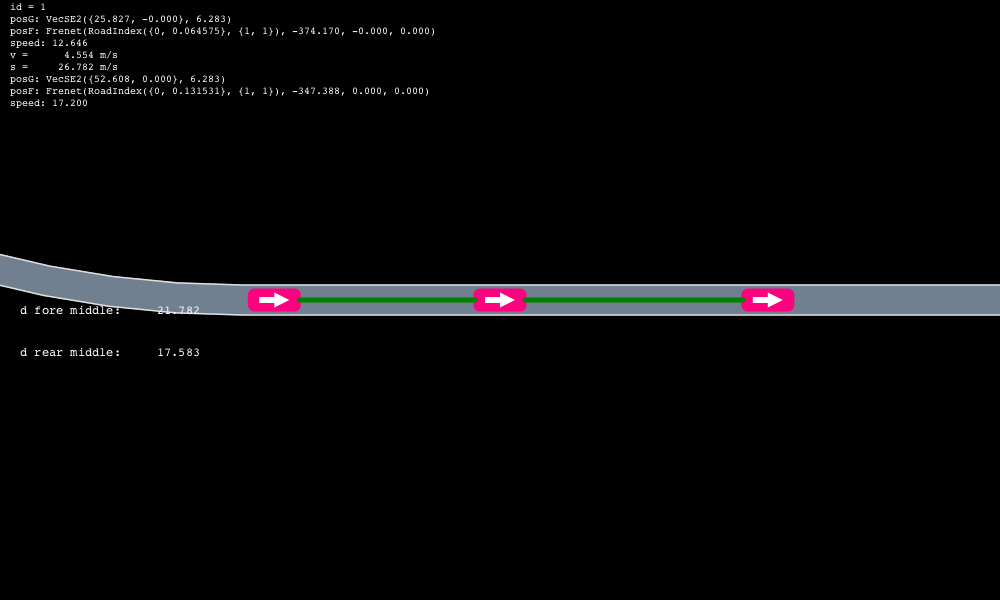

In [5]:
# check out vehicle id 1 at the start of the scenario
@manipulate for i in 0:(rec.nscenes - 1),
    veh_id in collect(1:num_veh)
    render(get_scene(rec, -(rec.nscenes - i)), 
            roadway, 
    [CarFollowingStatsOverlay(veh_id, 2), NeighborsOverlay(veh_id, textparams = TextParams(y_start=300))], 
            cam=CarFollowCamera(veh_id, 10.))
end